# Comparative study of EloMMR vs. The CodeChef Rating Sytem

In this notebook, we look at the EloMMR vs. CodeChef Rating System across the history of CodeChef contests. As detailed in our [paper](https://github.com/EbTech/Elo-MMR/tree/master/paper), EloMMR is a robust, statiscally principled rating system for massive multiplayer contests. We developed this system primarily with coding competitions in mind, and have done extensive comparisons with the TopCoder and CodeChef rating systems. The main benefits of EloMMR are:
- Speed and accuracy. EloMMR is at least an order of magnitude (typically more) faster than existing rating systems, and more accurate as well.
- Incentive-compatibility. EloMMR does not incentivize players to perform less than their best (unlike TopCoder and CodeChef, which can be attacked through so-called "volatility farming" attacks).
- Transparency. The entire codebase is open-source, and can be found [here](https://github.com/EbTech/Elo-MMR).

At the present moment, EloMMR has been implemented in production at [dmoj.ca](dmoj.ca), a contest system used primarily by Canadian competitive programmers. Our goal with this notebook will be to verify the above benefits on the CodeChef contest data, and to inform a transition from the CodeChef rating system to EloMMR. 

In [10]:
import os
import pandas as pd
from tqdm.notebook import tqdm

First, we do some data cleaning / preprocessing. The code below will read the following:
- All CodeChef contests since it's inception
- Monthly checkpoints of CodeChef ratings
- Monthly checkpoints of EloMMR ratings
- Various metadata (contest times, CodeChef numerical handles, etc.)

The monthly checkpoints were computed from our rust codebase using the `codechef_checkpoints.rs` file. The entire CodeChef history of 667 contests (at the time of writing) took approximately 27 seconds to complete using our `mmr-fast` algorithm.

In [167]:
from collections import defaultdict, Counter
import json

# Read in mappings of ids to username
root_dir = '/home/work_space/elommr-data'
user_csv = pd.read_csv(f'{root_dir}/user_ids_usernames_mapping.csv')

# For some reason user 33713 is not known
user_map = defaultdict(lambda: 'unknown_user')
userid_map = defaultdict(lambda: -1)
for userid, username in zip(user_csv.userid, user_csv.username):
    user_map[userid] = username
    userid_map[username] = userid
    
# Read in Codechef ranklist + our ranking system
codechef_dir = f'{root_dir}/ratings'
elommr_dir = f'{root_dir}/elommr-checkpoints/codechef'

# Set of contest names that are checkpointed
checkpoint_contests = set([contest[:-4] for contest in os.listdir(codechef_dir) if contest[-4:] == '.csv'])

# Get contest ids corresponding to these contest names
raw_contests = f'{root_dir}/var/www/elo_mmr/current/cache/codechef'
name_to_id, id_to_name, name_to_time = {}, {}, {}
all_contests = [contest for contest in os.listdir(raw_contests) if contest[-5:] == '.json']
all_contests = sorted(all_contests, key=lambda x: int(x[:-5]))

# Go through history of contests and get number of contests participated in by each user
# Also compute some mappings of contest names to contest ids
num_contests = Counter()
for contest in tqdm(all_contests):
    ranks = json.load(open(f'{raw_contests}/{contest}'))
    cid = int(contest[:-5])
    contest_name = ranks['name']
    
    name_to_id[ranks['name']] = cid
    id_to_name[cid] = contest_name
    name_to_time[contest_name] = ranks['time_seconds']
    
    num_contests.update([user_map[int(r[0])] for r in ranks['standings']])
    if contest_name in checkpoint_contests:
        # Save number of contests participated in by each user
        df = pd.DataFrame(data={'username': list(num_contests.keys()), 'num_contests': list(num_contests.values())})
        df.to_csv(f'{root_dir}/elommr-checkpoints/codechef/{contest_name}_numcontests.csv')

  0%|          | 0/689 [00:00<?, ?it/s]

## Measuring accuracy: rank deviation

In the code below, we measure a simple statistic for accuracy: the rank deviation. The rank deviation is the expected percentage your predicted rank (from the rating system) differs from your actual rank in the contest. Mathematically, the rank deviation of a player $i$ in a contest with $n$ participants is: 

$$\text{rank_deviation}_i = |\text{actual_rank}_i - \text{predicted_rank}_i| / n.$$

When player $i$ is tied with other players, we measure the difference of the actual rank to the nearest endpoint of the interval of players $i$ is tied with (or $0$ if the predicted rank lies within the interval).

In [244]:
import math
# For each contest, measure statistics between ranklists
def rank_dev(r, lo, hi):
    return min(abs(r - lo), abs(r - hi), 0 if lo <= r <= hi else math.inf)

def produce_rankings(pred):
    # Sort rankings by reverse rating
    return dict([(pred[0], i) for i, pred in enumerate(sorted(pred, key=lambda x: -x[1]))])

# Min number of contests a user needs to do before being counted in our metrics
min_experience_level = 3
default_rating = 1500

unknown_users = set()
rankdev_mmr, rankdev_cc = 0, 0
pairinv_mmr, pairinv_cc = 0, 0
num_obs = 0

checkpoint_contests = sorted(list(checkpoint_contests), key=lambda x: name_to_id[x])
for contest in tqdm(checkpoint_contests):
    # Get the contest data corresponding to contest following this checkpoint
    contest_id = name_to_id[contest] + 1
    ranks = json.load(open(f'{raw_contests}/{contest_id}.json'))
    
    if ranks['time_seconds'] >= name_to_time['START25B']:
        default_rating = 1000
        
    codechef_rank = pd.read_csv(f'{codechef_dir}/{contest}.csv')
    codechef_rank.sort_values(['ratings'], ascending=False, inplace=True)
    rate_name_cc = defaultdict(lambda: default_rating)
    rate_name_cc.update(dict(zip(codechef_rank.username, codechef_rank.ratings)))
    
    mmr_rank = pd.read_csv(f'{elommr_dir}/{contest}.csv')
    # Translate handle ids to actual usernames
    mmr_rank.handle = mmr_rank.handle.apply(lambda x: user_map[x])
    rate_name_mmr = defaultdict(lambda: default_rating)
    rate_name_mmr.update(dict(zip(mmr_rank.handle, mmr_rank.display_rating)))
    
    # For each user in the contest, get their predicted rank from both ranklists
    mmr_pred, codechef_pred = [], []
    for result in ranks['standings']:
        user = user_map[int(result[0])]
        if user != 'unknown_user':
            mmr_pred.append((user, rate_name_mmr[user]))
            codechef_pred.append((user, rate_name_cc[user]))
        else:
            unknown_users.add(int(result[0]))
    
    # Sort the predictions to get the actual rankings
    mmr_final, codechef_final = produce_rankings(mmr_pred), produce_rankings(codechef_pred)
    
    # Get the number of contests each user has participated in thus far
    num_contest_csv = pd.read_csv(f'{elommr_dir}/{contest}_numcontests.csv')
    num_contests = dict(zip(num_contest_csv.username, num_contest_csv.num_contests))
    
    # Compute various statistics over users that have participated in at least 3 contests
    num_participants = len(ranks['standings'])
    for result in ranks['standings']:
        user = user_map[int(result[0])]
        if user not in num_contests or num_contests[user] < min_experience_level:
            # Note: num_contests includes the current contest, so an entry of 3 indicates 2 contests have been done
            # before the current one
            continue
        
        r_mmr = mmr_final[user]
        r_cc = codechef_final[user]
        
        rankdev_mmr += rank_dev(r_mmr, *result[1:]) / num_participants
        rankdev_cc += rank_dev(r_cc, *result[1:]) / num_participants
        
        num_obs += 1
    
print('Ranking deviation percentage (mmr vs. cc):', rankdev_mmr / num_obs, rankdev_cc / num_obs)

  0%|          | 0/158 [00:00<?, ?it/s]

Ranking deviation percentage (mmr vs. cc): 0.1846255006533524 0.19375879824853307


As expected, the EloMMR algorithm is slightly more accurate with a lower ranking deviation metric.

# Distribution and support of ratings

Next, we'll plot the distribution of the ratings. The code below does this. In addition, it plots the ratings of the top-3 participants according to the rating system.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


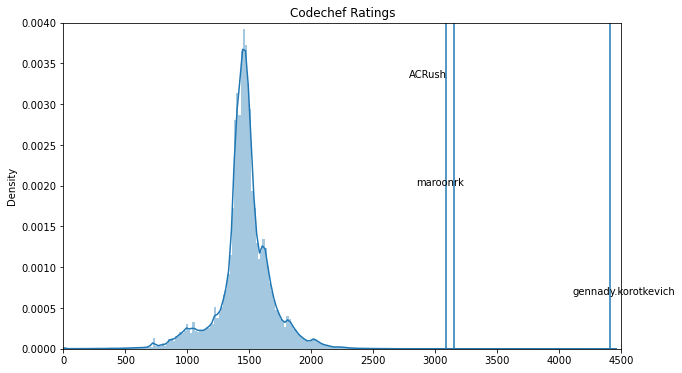

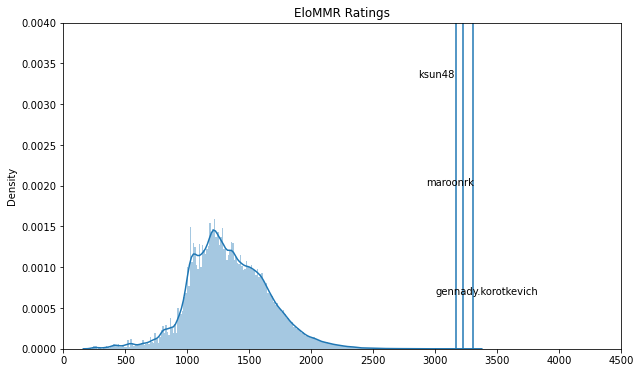

In [257]:
import seaborn
from matplotlib import rcParams
import matplotlib.pyplot as plt

# Add same columns to mmr ratings
mmr_rank['username'] = mmr_rank.handle
mmr_rank['ratings'] = mmr_rank.display_rating

rcParams['figure.figsize'] = (10, 6)

xlo, xhi = 0, 4500
ylo, yhi = 0, 0.004
def plot_top_k(rankings, k=3):
    for i in range(k):
        plt.axvline(rankings.ratings.iloc[i])
        plt.text(rankings.ratings.iloc[i] - 300, (i+1/2) * yhi / k, rankings.username.iloc[i])
        
def plot_distribution(rankings, title):
    plt.figure()
    data = pd.DataFrame(data={'data': rankings.ratings})
    ax = seaborn.distplot(data, bins=250)
    plot_top_k(rankings)
    ax.set_xlim([xlo, xhi]);
    ax.set_ylim([ylo, yhi]);
    ax.set_title(title);

plot_distribution(codechef_rank, 'Codechef Ratings')
plot_distribution(mmr_rank, 'EloMMR Ratings')

We see that EloMMR exhibits a much tighter range of support, whereas ratings for CodeChef are significantly inflated. In particular, the rating gap between `gennady.korotkevich` and second place `maroonrk` reach almost 1300 for CodeChef, but is only 80 points in EloMMR. CodeChef also tends to overuse the middle range of the distribution (around 1500), whereas EloMMR ratings are spread much more smoothly.

# Top-50 Ranking Differences

Let's first take a look at the raw ranklists of the top 50. On the left we have CodeChef, and on the right we have EloMMR.

In [283]:
cc_top50 = codechef_rank.iloc[:50]
mmr_top50 = mmr_rank[['username', 'ratings']].iloc[:50]

combined = pd.concat([d.reset_index(drop=True) for d in [cc_top50, mmr_top50]], axis=1)
color = (combined.username == 'maroonrk').map({True: 'background-color: green', False: ''})
combined.style.apply(lambda s: color)
display(combined)

AttributeError: 'DataFrame' object has no attribute 'map'

We see many common names in the top-10. Let's quantify exactly what the overlap is.

In [281]:
overlap = set(cc_top50.username) & set(mmr_top50.username)

print('Overlapping top-50 players:')
print(overlap)
print('Size of overlap:', len(overlap), '\n')

print('Unique EloMMR players:', set(mmr_top50.username) - overlap)
print('Unique CodeChef players:', set(cc_top50.username) - overlap)

Overlapping top-50 players:
{'lhic', 'peehs_moorhsum', 'progmatic', 'ACRush', 'msm1993', 'kutengine', 'lyrically', 'spycheese', 'rns5', 'alex_2oo8', 'he_____he', 'heno239', 'mugurelionut', 'oilhun', 'ccz181078', 'ceilks', 'kut_hbi1998', 'ksun48', 'rns4', 'neal', 'maksim1744', 'kal013', 'petr', 'endagorion', 'maroonrk', 'tmwilliamlin', 'white2302', 'sansen', 'tmyklebu', 'bigbag', 'geothermal', 'gennady.korotkevich', 'um_nik', 'noimi'}
Size of overlap: 34 

Unique EloMMR players: {'skyfire', 'tute7627', 'wrong_answer_1', 'scheffeli', 'wasa855', 'ssrs', 'kotatsugame', 'grumpy_gordon', 'hitonanode', 'rns_cus', 'vercingetorix', 'potato167', 'xaphoenix', 'uwi', 'jeroenodb', 'natsugiri'}
Unique CodeChef players: {'waterfalls', 'hh_algos', 'stonefeang', 'kut_hgs1997', 'fjzzq2002', 'ecnerwala', 'ryodan', 'algmyr', 'Fdg', 'iafir', 'dj3500', 'gainullinildar', 'isaf27', 'gorre_morre', 'aawisong', 'b524'}


Almost 70% of the top-50 list overlaps. Next, let's look at the relationship between CodeChef and EloMMR ratings.